# Airline Tickets Price Prediction
## Loading Libraries and Dataset

In [1]:
# Data Handling Libraries
import numpy as np
import pandas as pd

In [2]:
# Visulaization Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [76]:
# Model Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [86]:
# dump model
import pickle

In [4]:
# suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# suppress scientific notation
pd.options.display.float_format = "{:0.2f}".format

# setting display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [6]:
# reading data
df = pd.read_excel('Data_Train.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [7]:
# dataframe shape
df.shape

(10683, 11)

## Data Cleaning
### Missing value Imputation

In [8]:
# utility method to return columns with missing values for given cutoff value
def get_missing_value_columns(df, cut_off=0):
    """Function to return columns in dataframe with missing/null values in percentage"""
    missing_columns = round(100*(df.isnull().sum() / df.shape[0]).sort_values(ascending=False), 2)
    print(f"There are {len(missing_columns.loc[missing_columns > cut_off])} features having more than {cut_off}% missing values")
    return missing_columns.loc[missing_columns > cut_off]

In [9]:
# getting missing value information
get_missing_value_columns(df)

There are 2 features having more than 0% missing values


Total_Stops   0.01
Route         0.01
dtype: float64

In [10]:
# missing value count
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

We can observe that there is very little missing values. Hence we can drop them.

In [11]:
# dropping the missing values
df.dropna(inplace=True)

In [12]:
# checking missing values again
get_missing_value_columns(df)

There are 0 features having more than 0% missing values


Series([], dtype: float64)

In [13]:
# checking datatypes
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [14]:
# converting to datetimes from object
def convert_to_datetime(col):
    """Converting feature type to datetime"""
    df[col] = pd.to_datetime(df[col])

In [15]:
# converting cols to datetime
for col in ['Date_of_Journey', 'Dep_Time', 'Arrival_Time']:
    convert_to_datetime(col)

In [16]:
# checking datatypes
df.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

### Derived Features

In [17]:
# extracting day and month as separate features
df['Journey_day'] = df['Date_of_Journey'].dt.day
df['Journey_month'] = df['Date_of_Journey'].dt.month

In [18]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2021-07-01 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-07-01 05:50:00,2021-07-01 13:15:00,7h 25m,2 stops,No info,7662,5,1
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2021-07-01 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882,6,9
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2021-07-01 18:05:00,2021-07-01 23:30:00,5h 25m,1 stop,No info,6218,5,12
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2021-07-01 16:50:00,2021-07-01 21:35:00,4h 45m,1 stop,No info,13302,3,1


In [19]:
# dropping Date_of_Journey column as it is redundant now
df.drop('Date_of_Journey', axis=1, inplace=True)

In [20]:
# function to extract hour from date feature
def extract_hour(df, col):
    """Extracting Hour data from the feature"""
    df[col + '_hour'] = df[col].dt.hour

In [21]:
# function to extract minutes from date feature
def extract_minute(df, col):
    """Extracting Hour data from the feature"""
    df[col + '_minute'] = df[col].dt.minute

In [22]:
# function to drop a feature
def drop_feature(df, col):
    """Dropping feature from dataframe"""
    df.drop(col, axis=1, inplace=True)

In [23]:
# performing above ops on departure time
extract_hour(df, 'Dep_Time')
extract_minute(df, 'Dep_Time')
drop_feature(df, 'Dep_Time')

In [24]:
# performing above ops on Arrival time
extract_hour(df, 'Arrival_Time')
extract_minute(df, 'Arrival_Time')
drop_feature(df, 'Arrival_Time')

In [25]:
# checking dataframe
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


In [26]:
# streamlining the duration column for consistency - In some mins are missing and in some hours missing
def streamline_duration(data):
    """Streamlines the feature column for consistency"""
    data_split = data.split()
    if len(data_split) != 2:
        if data_split[0][-1] == 'h':
            data = data + ' 0m'
        else:
            data = '0h ' + data
    return data

In [27]:
# applying transformation to the duration column
df['Duration'] = df['Duration'].apply(lambda x: streamline_duration(x))

In [28]:
# checking values of duration
df['Duration'].head(10).to_dict()

{0: '2h 50m',
 1: '7h 25m',
 2: '19h 0m',
 3: '5h 25m',
 4: '4h 45m',
 5: '2h 25m',
 6: '15h 30m',
 7: '21h 5m',
 8: '25h 30m',
 9: '7h 50m'}

### Data Preprocessing

In [29]:
# function to extract hour from duration
def extract_hour(time):
    """Extracts hour from the given duration time"""
    return int(time.split()[0][:-1])

In [30]:
# function to extract minutes from duration
def extract_minutes(time):
    """Extracts minutes from the given duration time"""
    return int(time.split()[1][:-1])

In [31]:
# creating new columns out of derived features
df['Duration_hours'] = df['Duration'].apply(extract_hour)
df['Duration_mins'] = df['Duration'].apply(extract_minutes)

In [32]:
# checking the df
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35,4,45


In [33]:
# dropping Duration column
drop_feature(df, 'Duration')

In [34]:
# checking data types
df.dtypes

Airline                object
Source                 object
Destination            object
Route                  object
Total_Stops            object
Additional_Info        object
Price                   int64
Journey_day             int64
Journey_month           int64
Dep_Time_hour           int64
Dep_Time_minute         int64
Arrival_Time_hour       int64
Arrival_Time_minute     int64
Duration_hours          int64
Duration_mins           int64
dtype: object

In [35]:
# extracting categorical and numerical columns
categorical_cols = [col for col in df.columns if df[col].dtype == 'O']
numerical_cols = [col for col in df.columns if df[col].dtype != 'O']
print(categorical_cols, '\n', numerical_cols)

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info'] 
 ['Price', 'Journey_day', 'Journey_month', 'Dep_Time_hour', 'Dep_Time_minute', 'Arrival_Time_hour', 'Arrival_Time_minute', 'Duration_hours', 'Duration_mins']


### Feature Encoding 
Handling categorical data using feature encoding
- Nominal data: No order/heirarchy - use OneHot encoding
- Ordinal data: There is order/heirarchy - use LabelEncoder
#### OneHot Encoding

In [36]:
# extracting categorical data
categorical_data = df[categorical_cols]
categorical_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info


In [37]:
# checking distribution of Airline column
categorical_data['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

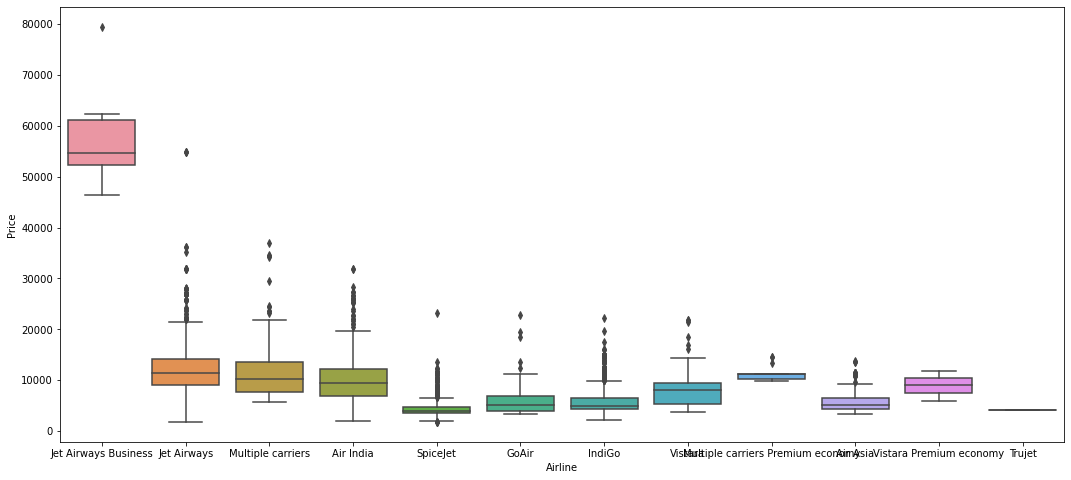

In [38]:
# box plot for Airline feature
plt.figure(figsize=(18, 8))
sns.boxplot(x='Airline', y='Price', data=df.sort_values('Price', ascending=False))
plt.show()

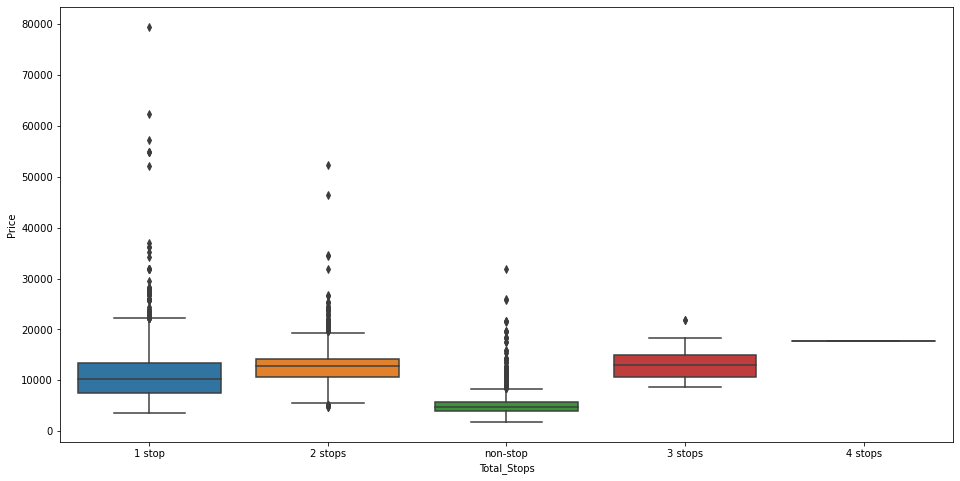

In [39]:
# box plot for Total_Stops feature
plt.figure(figsize=(16, 8))
sns.boxplot(x='Total_Stops', y='Price', data=df.sort_values('Price', ascending=False))
plt.show()

In [40]:
# one hot encoding for Airline
airline = pd.get_dummies(categorical_data['Airline'], drop_first=True)
airline.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [41]:
# value counts for source column
categorical_data['Source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

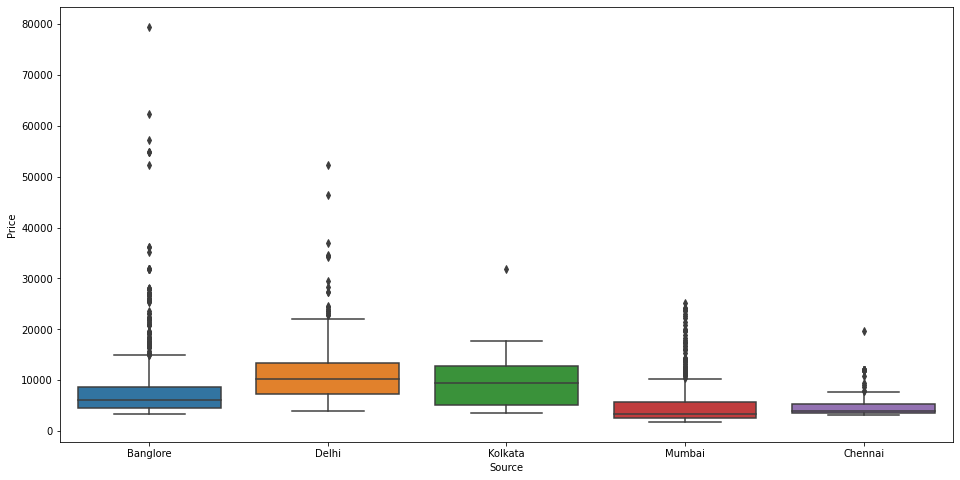

In [42]:
# box plot for Source feature
plt.figure(figsize=(16, 8))
sns.boxplot(x='Source', y='Price', data=df.sort_values('Price', ascending=False))
plt.show()

In [43]:
# one hot encoding for Source
source = pd.get_dummies(categorical_data['Source'], drop_first=True)
source.head()

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [44]:
# value counts for source column
categorical_data['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

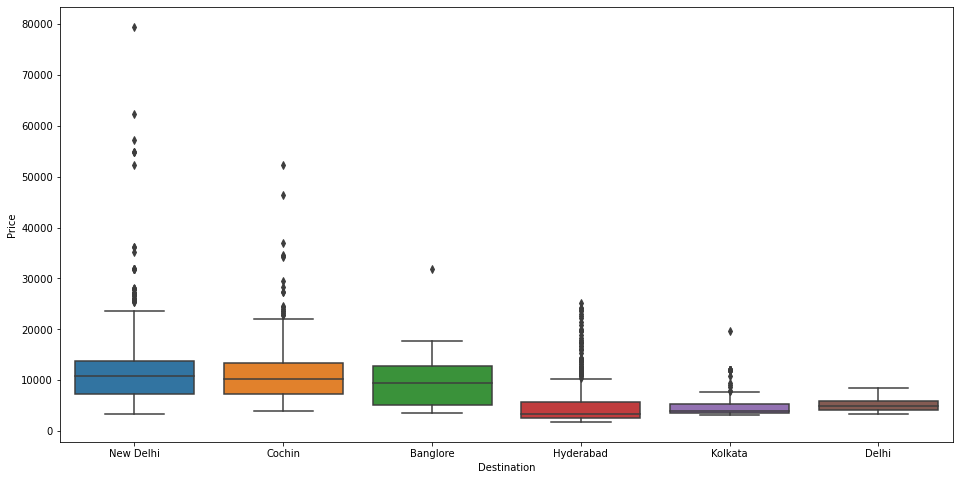

In [45]:
# box plot for Destination feature
plt.figure(figsize=(16, 8))
sns.boxplot(x='Destination', y='Price', data=df.sort_values('Price', ascending=False))
plt.show()

In [46]:
# one hot encoding for Source
destination = pd.get_dummies(categorical_data['Destination'], drop_first=True)
destination.head()

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


#### Label Encoding

In [47]:
# splitting routes in to multiple routes
categorical_data['Route_1'] = categorical_data['Route'].str.split('→').str[0]
categorical_data['Route_2'] = categorical_data['Route'].str.split('→').str[1]
categorical_data['Route_3'] = categorical_data['Route'].str.split('→').str[2]
categorical_data['Route_4'] = categorical_data['Route'].str.split('→').str[3]
categorical_data['Route_5'] = categorical_data['Route'].str.split('→').str[4]

In [48]:
# checking categorical_data
categorical_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,BLR,NAG,DEL,NaN,NaN


In [49]:
# dropping the Route column
drop_feature(categorical_data, 'Route')

In [50]:
# checking missing values
categorical_data.isnull().sum()

Airline                0
Source                 0
Destination            0
Total_Stops            0
Additional_Info        0
Route_1                0
Route_2                0
Route_3             3491
Route_4             9116
Route_5            10636
dtype: int64

In [51]:
# replacing null with string None
for col in ['Route_3', 'Route_4', 'Route_5']:
    categorical_data[col].fillna('None', inplace=True)

In [52]:
# checking missing values
categorical_data.isnull().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Additional_Info    0
Route_1            0
Route_2            0
Route_3            0
Route_4            0
Route_5            0
dtype: int64

In [53]:
# checking number of categories for each categorical columns
for col in categorical_data.columns:
    print(f"{col} has a total of {categorical_data[col].nunique()} categorices")

Airline has a total of 12 categorices
Source has a total of 5 categorices
Destination has a total of 6 categorices
Total_Stops has a total of 5 categorices
Additional_Info has a total of 10 categorices
Route_1 has a total of 5 categorices
Route_2 has a total of 45 categorices
Route_3 has a total of 30 categorices
Route_4 has a total of 14 categorices
Route_5 has a total of 6 categorices


In [54]:
# creating label encoder object
label_encoder = LabelEncoder()

In [55]:
# get columns
categorical_data.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5'],
      dtype='object')

In [56]:
# label encoding for feature columns
for col in ['Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']:
    categorical_data[col] = label_encoder.fit_transform(categorical_data[col])

In [57]:
# checking the categorical df
categorical_data.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,non-stop,No info,0,13,29,13,5
1,Air India,Kolkata,Banglore,2 stops,No info,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2 stops,No info,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1 stop,No info,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1 stop,No info,0,34,8,13,5


In [58]:
# dropping Additional_Info since it majorly contains 'No info'
drop_feature(categorical_data, 'Additional_Info')

In [59]:
# unique values for Total_Stops
categorical_data['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [60]:
# mapping Total_Stops to dict of required data
dict1 = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
categorical_data['Total_Stops'] = categorical_data['Total_Stops'].map(dict1)
categorical_data.head()

,Airline,Source,Destination,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5
1,Air India,Kolkata,Banglore,2,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5


In [61]:
# concating all one hot encoded features, categorical data and conteinous data
df = pd.concat([categorical_data, airline, source, destination, df[numerical_cols]], axis=1)
df.head()

,Airline,Source,Destination,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,Journey_day,Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13302,3,1,16,50,21,35,4,45


In [62]:
# dropping airline, source and destination column as it encoded
drop_feature(df, 'Airline')
drop_feature(df, 'Source')
drop_feature(df, 'Destination')

In [63]:
# checking df
df.head()

,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,Journey_day,Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3897,24,3,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7662,5,1,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,13882,6,9,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6218,5,12,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13302,3,1,16,50,21,35,4,45


### Outliers Detection

In [64]:
# function to plot 
def plot_distributions(df, col):
    """Plots box and dist plot for a feature to observe the distribution"""
    fig, (ax1, ax2) = plt.subplots(2, 1)
    sns.distplot(df[col], ax=ax1)
    sns.boxplot(df[col], ax=ax2)

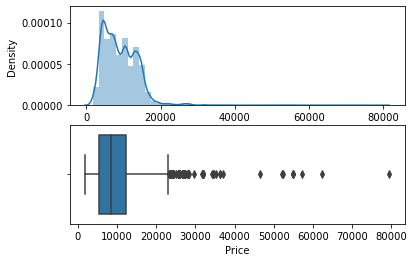

In [65]:
# plotting for price feature
plot_distributions(df, 'Price')

In [66]:
# updating the outlier values with the median
df['Price'] = np.where(df['Price'] >= 40_000, df['Price'].median(), df['Price'])

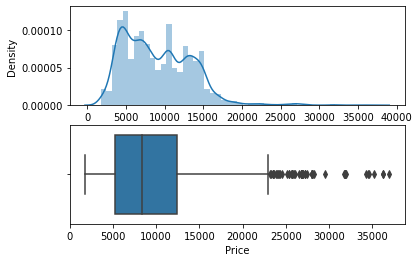

In [67]:
# plotting for price feature
plot_distributions(df, 'Price')

In [68]:
# creating X and y
y = df.pop('Price')
X = df
print('X', X.shape, '\ny', y.shape)

X (10682, 34) 
y (10682,)


### Best Feature Selection

In [71]:
# using info gain to see best features
mutual_info_data = mutual_info_classif(X, y)
mutual_info_data

array([2.18558974e+00, 2.07629197e+00, 2.78432517e+00, 2.30548911e+00,
       1.47632567e+00, 7.05073424e-01, 7.49389026e-01, 1.00531935e-01,
       6.58197646e-01, 9.29121892e-01, 0.00000000e+00, 5.82374446e-01,
       7.45601218e-03, 3.06980988e-01, 0.00000000e+00, 2.21822444e-01,
       5.19799499e-04, 1.57546649e-01, 1.51959654e+00, 8.94437146e-01,
       2.86333717e-01, 1.51719283e+00, 4.18603876e-01, 2.90042040e-01,
       1.86456499e-01, 3.77960274e-01, 1.09851298e+00, 8.73198187e-01,
       1.39405098e+00, 1.20297220e+00, 1.80844948e+00, 1.54303290e+00,
       1.76716098e+00, 1.07815801e+00])

In [72]:
imp_features = pd.DataFrame(mutual_info_data, index=X.columns)
imp_features

,0
Total_Stops,2.19
Route_1,2.08
Route_2,2.78
Route_3,2.31
Route_4,1.48
Route_5,0.71
Air India,0.75
GoAir,0.10
IndiGo,0.66
Jet Airways,0.93


In [73]:
imp_features.columns = ['Importance']
imp_features.sort_values('Importance', ascending=False)

,Importance
Route_2,2.78
Route_3,2.31
Total_Stops,2.19
Route_1,2.08
Arrival_Time_hour,1.81
Duration_hours,1.77
Arrival_Time_minute,1.54
Delhi,1.52
Cochin,1.52
Route_4,1.48


## Model Building
Applying Ml and automating the predictions

In [75]:
# performing a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [87]:
# function to predict the data
def predict(ml_model, dump=False):
    """Predicts on the data for the given model"""
    model = ml_model.fit(X_train, y_train)
    print(f"Training score: {model.score(X_train, y_train)}")
    y_pred = model.predict(X_test)
    print(f"Predictions are:\n {y_pred}", "\n")
    
    # calculating metrics
    r2_sc = metrics.r2_score(y_test, y_pred)
    print(f"r2 score: {r2_sc}")
    print(f"Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred)}")
    mse = metrics.mean_squared_error(y_test, y_pred)
    print(f"MSE: {mse}")
    print(f"RMSE: {np.sqrt(mse)}")
    
    # plot pred vs data
    sns.distplot(y_test-y_pred)
    
    if dump:
        with open('model.pkl', 'wb') as file:
            pickle.dump(model, file)

#### Random Forest

In [78]:
from sklearn.ensemble import RandomForestRegressor

Training score: 0.9544052882134888
Predictions are:
 [12845.28       11281.85216667  4232.51       ... 16416.94
  3544.367       7488.9       ] 

r2 score: 0.8108611273459533
Mean Absolute Error: 1161.5723720165604
MSE: 3623242.7393669444
RMSE: 1903.481741274905


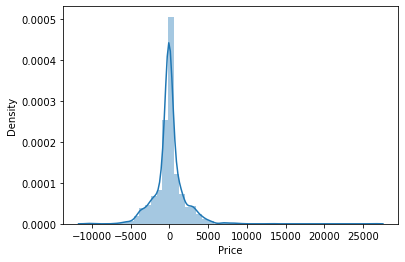

In [85]:
# predicting using Random Forest
predict(RandomForestRegressor())

#### Multiple Models

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

Training score: 0.619099335406482
Predictions are:
 [10722.69577613 12445.38030708  4285.30735025 ...  5567.89132624
  3609.36042693 11189.55629516] 

r2 score: 0.6019817533492393
Mean Absolute Error: 1943.9916759438245
MSE: 7624644.802397129
RMSE: 2761.275937387846


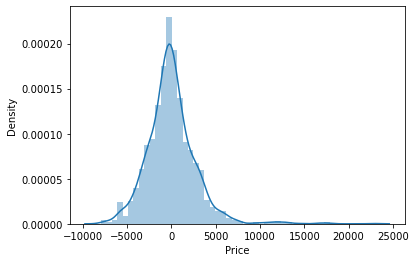

In [89]:
# using LR
predict(LinearRegression())

Training score: 0.9675137929108779
Predictions are:
 [12898.  11920.5  3943.  ... 12475.   3543.   7618. ] 

r2 score: 0.7172338990888942
Mean Absolute Error: 1330.4396038059583
MSE: 5416814.68060365
RMSE: 2327.405138905483


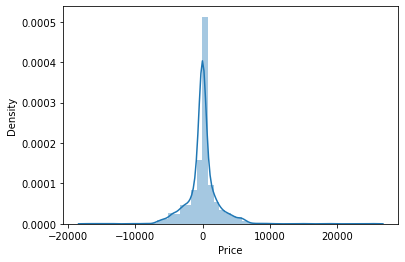

In [90]:
# using DT
predict(DecisionTreeRegressor())

Training score: 0.784762755499508
Predictions are:
 [10789.2 11809.8  4135.  ...  5967.8  3553.8 10438.2] 

r2 score: 0.6351254915700442
Mean Absolute Error: 1753.109312119794
MSE: 6989726.093308376
RMSE: 2643.809012260223


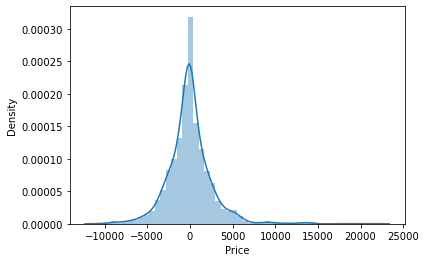

In [91]:
# using KNN
predict(KNeighborsRegressor())

## Hyperparameter Tuning & Cross Validation

In [92]:
from sklearn.model_selection import RandomizedSearchCV

In [95]:
# defining n_estimators and max_depth
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=6)]
max_depth = [int(x) for x in np.linspace(start=5, stop=30, num=4)]

In [96]:
# hyperparameters
random_grid = {
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt'],
    'max_depth': max_depth,
    'min_impurity_split': [5, 10, 15, 100]
}

In [97]:
# creating random forest model
rf = RandomForestRegressor()

In [98]:
# initiating cross validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, cv=3, verbose=2, n_jobs=-1)

In [99]:
# fit the model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_impurity_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 320, 540, 760,
                                                         980, 1200]},
                   verbose=2)

In [100]:
# best params
rf_random.best_params_

{'n_estimators': 320,
 'min_impurity_split': 10,
 'max_features': 'auto',
 'max_depth': 30}

In [102]:
# predict
pred = rf_random.predict(X_test)

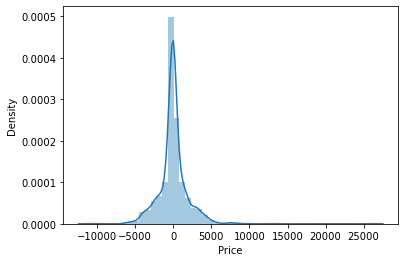

In [104]:
sns.distplot(y_test-pred)
plt.show()

In [105]:
# r2 score
metrics.r2_score(y_test, pred)

0.8112769617414457

In [106]:
# dumping the model
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_random, file)

In [107]:
with open('rf_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [108]:
model

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_impurity_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 320, 540, 760,
                                                         980, 1200]},
                   verbose=2)

In [109]:
pred2 = model.predict(X_test)

In [110]:
# r2 score
metrics.r2_score(y_test, pred2)

0.8112769617414457